# Introduction

### This document describes the development and analysis of the results of a Rogowski coil design and signal conditioning circuit

# Development
## Import of all modules

In [1]:
import femm
import time
import os
import numpy as np
import cmath as cm
import random
import pandas as pd 
from ipywidgets import IntProgress
from IPython.display import display
from scipy import fftpack
from scipy.io import wavfile
import matplotlib.pyplot as plt
%matplotlib inline

## cell for simulate a Rogowski coil in FEMM tool

In [2]:
femm.openfemm()
femm.opendocument("femm/rogowski_simulation.fem");
femm.mi_saveas("femm/temp.fem")
femm.mi_seteditmode("group")
vr=[];
f=[];

units = "millimeters"
stype = 'planar'
precision = 10**-8
depth = 1
minangle = 30
acsolver = 0 # 0 to successive approximation or 1 to Newton  

# number of interaction
init = 0
final = 4 

progress = IntProgress(min=init, max=final, description='Simulation:') # instantiate the bar
display(progress) # display the bar

init_time = time.time()

for n in range(init,final): 
    if n == 0:
        n=0.00001
        
    freq = 1000*n
    f.append(freq)
    femm.mi_probdef(freq,units,stype,precision,depth,minangle,(acsolver))
    femm.mi_analyze()
    femm.mi_loadsolution()
    femm.mo_groupselectblock(1)
    v=femm.mo_getcircuitproperties("Ir")
    vr.append(v[1]) # get the voltage drop of Ir
    progress.value = n+1
femm.closefemm()

print('Time: ' + str(time.time() - init_time) + 's')

IntProgress(value=0, description='Simulation:', max=4)

Time: 28.130938291549683s


## Plot of Rogowski coil frequency response 

Text(0.5, 0, 'Frequency [Hz]')

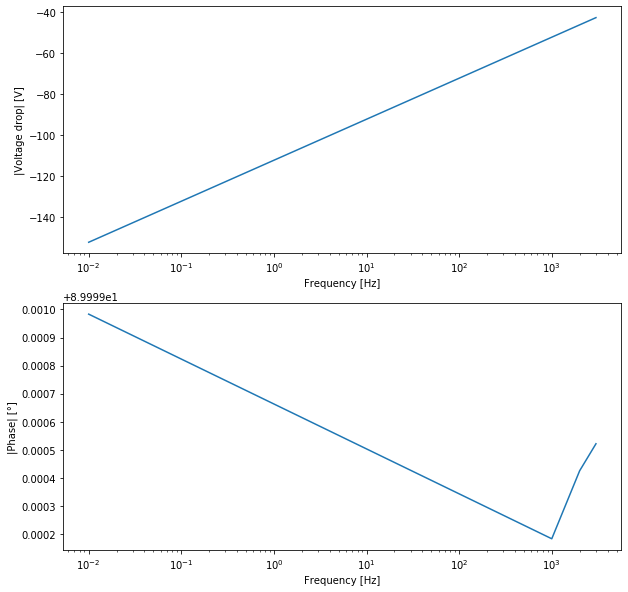

In [3]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10,10))
ax[0].semilogx(f,20*np.log10(np.abs(vr)/100))
ax[0].set_ylabel('|Voltage drop| [V]')
ax[0].set_xlabel('Frequency [Hz]')

ax[1].semilogx(f,np.angle(vr)*180/np.pi)
ax[1].set_ylabel('|Phase| [°]')
ax[1].set_xlabel('Frequency [Hz]')

## Gain of Rogowski Coil

In [4]:
gain = np.abs(vr[-1])/(100*f[-1])
gain

2.442818970228452e-06

## Read a file with real values of current, sampled in a didatic plant for vibration analysis

In [6]:
# read file
file_data = pd.read_csv('MotorDesbalanceado.csv')
    
# get set of data from .csv file
data = 330*file_data['Amperimeter']
len_data = len(data)
   
init = 0.5
final = 0.55

# sample Rate in Hz
f_s = 10000

data_plot = data[int(init*len_data+1):int(final*len_data)]
fft_data = fftpack.fft(data_plot)
amplitude = np.abs(fft_data)
phase = np.angle(fft_data)
freqs = fftpack.fftfreq(len(data_plot)) * f_s

## Another possibility, is create a new signal with white noise, creating a more controllable scenario to simulate

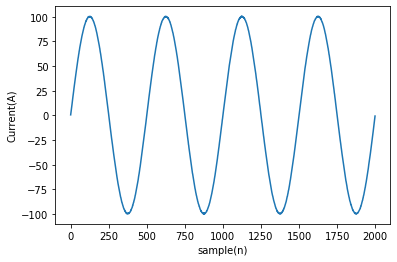

In [7]:
# create a signal with white noise
Fs = 10000
f = 20
x = np.arange(len_data)
noise = 2e-8*np.asarray(random.sample(range(0,len_data),len_data))
 
y_noise = 100*(np.sin(2 * np.pi * f * x / Fs)+noise)
plt.plot(y_noise[0:2000])
plt.ylabel('Current(A)')
plt.xlabel('sample(n)')
plt.show()

data_plot_sml = y_noise[int(init*len_data+1):int(final*len_data)]
fft_data_sml = fftpack.fft(data_plot_sml)
amplitude_sml = np.abs(fft_data_sml)
phase_sml = np.angle(fft_data_sml)
freqs_sml = fftpack.fftfreq(len(data_plot_sml)) * f_s

## Calculates the Rogowski voltage from the product between Rogowski coil frequency response and the currente imported from another sensor

In [9]:
AmplReal = []
PhsReal = []
polarReal = []

AmplSml = []
PhsSml = []
polarSml = []

for n in range(0, len(freqs)):
    AmplReal.append(amplitude[n]*gain*freqs[n])
    PhsReal.append(phase[n]*(180/np.pi) + 90)
    polarReal.append(cm.rect(AmplReal[n], PhsReal[n]))
    
    AmplSml.append(amplitude_sml[n]*gain*freqs_sml[n])
    PhsSml.append(phase_sml[n]*(180/np.pi) + 90)
    polarSml.append(cm.rect(AmplSml[n], PhsSml[n]))

## Rogowski voltage Frequency response of a real current

C:\Users\Gpiaia\Anaconda3.1\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  
C:\Users\Gpiaia\Anaconda3.1\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log10
  


Text(0.5, 0, 'Frequency [Hz]')

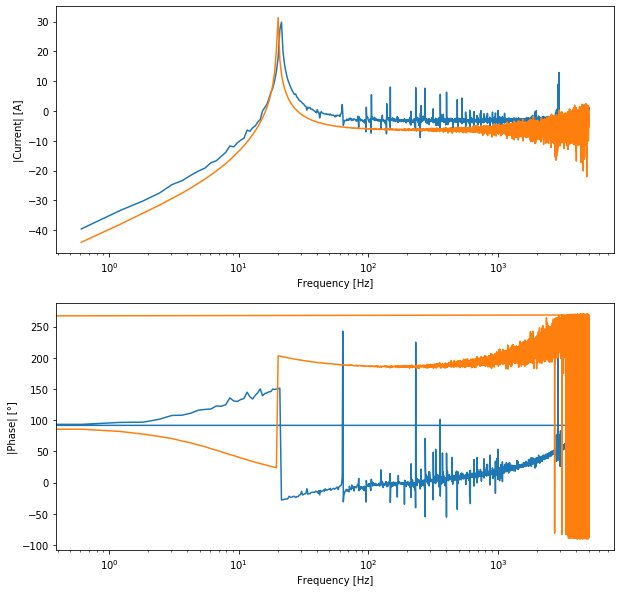

In [10]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10,10))
ax[0].semilogx(freqs,20*np.log10(AmplReal), freqs_sml,20*np.log10(AmplSml))
ax[0].set_ylabel('|Current| [A]')
ax[0].set_xlabel('Frequency [Hz]')

ax[1].semilogx(freqs,PhsReal, freqs_sml,PhsSml)
ax[1].set_ylabel('|Phase| [°]')
ax[1].set_xlabel('Frequency [Hz]')

## Inverse fft of the Rogowski voltage of a real current

C:\Users\Gpiaia\Anaconda3.1\lib\site-packages\numpy\core\numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


(-0.025, 0.025)

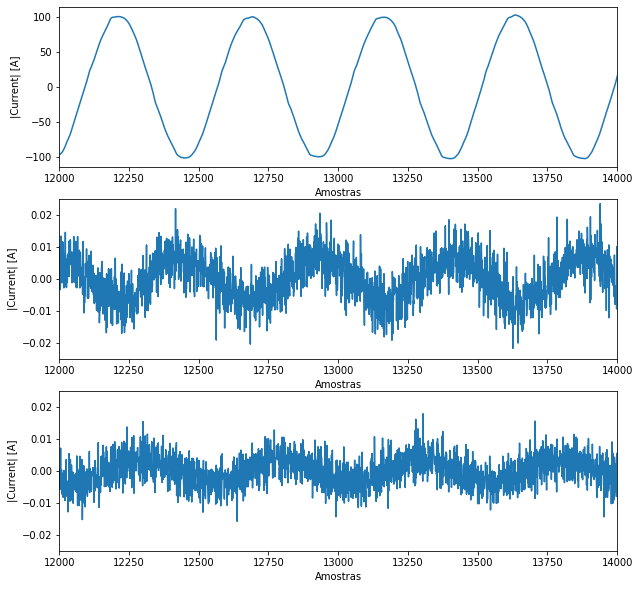

In [11]:
signal_rogowski_real = fftpack.ifft(polarReal)
signal_rogowski_sml = fftpack.ifft(polarSml)

# plot and compare ifft with a real current
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(10,10))
ax[1].plot(signal_rogowski_real)
ax[1].set_ylabel('|Current| [A]')
ax[1].set_xlabel('Amostras')
ax[1].set_xlim(12000, 14000)
ax[1].set_ylim(-0.025, 0.025)

ax[0].plot(data)
ax[0].set_ylabel('|Current| [A]')
ax[0].set_xlabel('Amostras')
ax[0].set_xlim(12000, 14000)

ax[2].plot(signal_rogowski_sml)
ax[2].set_ylabel('|Current| [A]')
ax[2].set_xlabel('Amostras')
ax[2].set_xlim(12000, 14000)
ax[2].set_ylim(-0.025, 0.025)

In [13]:
# Exports to wav file the Rogowski voltage of a real current
sampleRate = 10000
wave = 1000000000*(np.real(signal_rogowski_real[10000: 14000]))
iwave = wave.astype(int)

wavfile.write('ltspice/vRogowski.wav', sampleRate, iwave)

In [14]:
# Exports to wav file the Rogowski voltage of a real current
sampleRate = 10000
wave = 1000000000*(np.real(signal_rogowski_sml[10000: 14000]))
iwave = wave.astype(int)

wavfile.write('ltspice/vRogowskiSml.wav', sampleRate, iwave)

## LTspice Simulations

### In this step, the simulated results are imported to compare with original current.

![Simulated Circuit in LTspice](images/monte_carlo.png)

### The folowing image, represents the simulated circuit. 

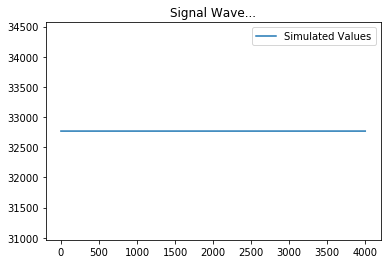

In [13]:
# imports a wav file from a LTspice simulation and compare with de  signal with white noise
wav_data = wavfile.read('ltspice/output3.wav', sampleRate)
init = 0
final = 4000
plt.figure(1)
plt.title('Signal Wave...')
plt.plot(wav_data[1][init:final], label='Simulated Values')
#plt.plot(y_noise[init:final], label='Real Current')
plt.legend()
plt.show()

# Monte Carlo Simulation

### The folowing image, represents the Monte Carlo  simulated circuit. 

![Simulated Circuit in LTspice](images/monte_carlo.png)

#### And below, the implementation of a function to parse a .txt file with results of simulation

In [15]:
data = []
frequency = []
aux = []
ampl = []
ph = []
cnt_step = -1

with open ("ltspice/MC_AC_AnalogRogowskiSignalProc.txt", "r") as myfile:
    for line in  myfile:
        data.append(line)            

data.pop(0)

for y in data:
    aux = y.split(" ")
    if(aux[0] == 'Step'):
        cnt_step = cnt_step + 1
        frequency.append([])
        ampl.append([])
        ph.append([])
        
    else:    
        aux = y.split("	")
        frequency[cnt_step].append(float(aux[0]))
        aux = aux[1].split(",")
        r=float(aux[0])
        im=float(aux[1].strip('\n'))
        polar = cm.polar(complex(r, im))
        ampl[cnt_step].append(polar[0]) 
        ph[cnt_step].append(polar[1]*180/np.pi) 

### Plot of Rogowski coil frequency response in Monte Carlo Simulation

Text(0.5, 0, 'Frequency [Hz]')

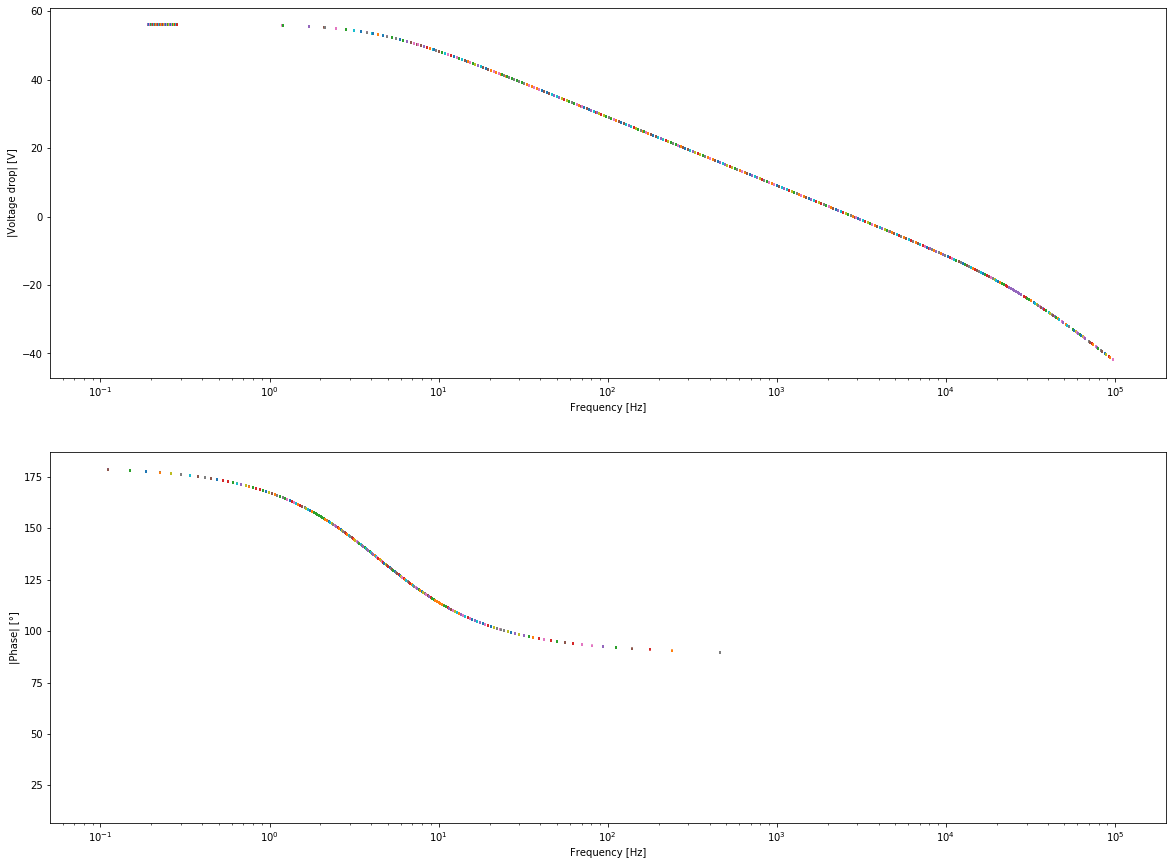

In [16]:

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(20,15))
ax[0].semilogx(frequency, 20*np.log10(np.abs(ampl)))
ax[0].set_ylabel('|Voltage drop| [V]')
ax[0].set_xlabel('Frequency [Hz]')

ax[1].semilogx(frequency,ph)
ax[1].set_ylabel('|Phase| [°]')
ax[1].set_xlabel('Frequency [Hz]')

### Calculation of the frequency error of the signal conditioning circuit

In [17]:
ampl_err = []
ph_err = []

# Teorical Model from SAPWin Simulator
def teorico(w):
    num = + ( +200000 )+ ( +20000j )*w
    den = + ( +312000 )+ ( +42400j )*w - ( +1120 )*w**2
    rect =  1000*num/den
    polar = cm.polar(complex(rect.real, rect.imag))
    return polar

# For loop for calulate the error of Monte Carlo Results
for y in range(0,len(ampl)):
    ampl_err.append([])
    ph_err.append([])
    for x in range(0,len(ampl[0])):
        tvalue = teorico(2*frequency[y][x]*np.pi)
        ampl_err[y].append(((tvalue[0] - ampl[y][x])/tvalue[0])*100)
        ph_err[y].append(((tvalue[1]*180/np.pi - ph[y][x])/(tvalue[1]*180/np.pi))*100)

### Plot of Error in frequency of Monte Carlo results of conditioning circuit simulations 

Text(0.5, 0, 'Frequncia [Hz]')

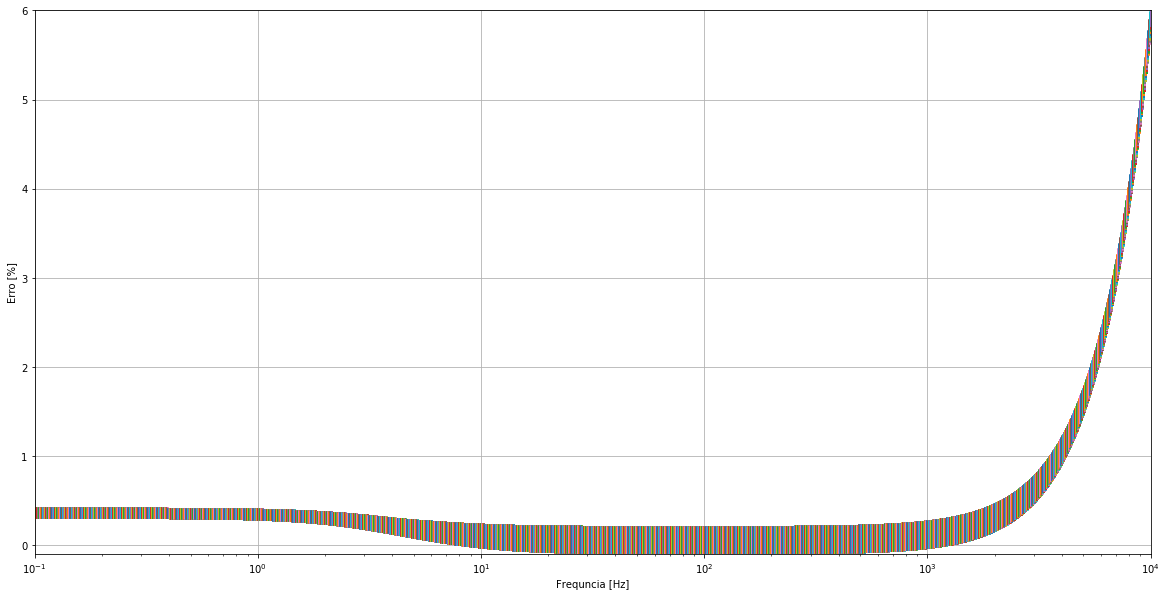

In [25]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,10))
ax.semilogx(frequency, ampl_err)
ax.set_ylabel('Erro [%]')
ax.set_xlim(0.1,10000)
ax.set_ylim(-0.1,6)
ax.grid(True)
ax.set_xlabel('Frequncia [Hz]')